In [1]:
import weakref
import functools

import cabinetry
import jax
import numpy
import scipy
import scipy.special
from tensorflow_probability.substrates import jax as tfp

from matplotlib import pyplot

from pyhf_stuff import blind, region

In [2]:

# region functions

# cache to avoid recompilation, weakref to clean up if the region object no
# longer exists elsewhere
# TODO make this a lazy property on region object
_region_functions_cache = weakref.WeakKeyDictionary()


def region_state(region):
    if region in _region_functions_cache:
        return _region_functions_cache[region]

    result = RegionState(region)
    _region_functions_cache[region] = result
    return result


class RegionState:
    """Parameters and jax-jitted functions for a region."""

    def __init__(self, region):
        model = region.workspace.model()
        data = region.workspace.data(model)
        model_blind = blind.Model(model, {region.signal_region_name})

        # parameters
        self.init = numpy.array(model.config.suggested_init())
        self.bounds = numpy.array(model.config.suggested_bounds())

        def logpdf(x):
            (logpdf,) = model_blind.logpdf(x, data)
            return logpdf

        self.logpdf = logpdf

        # "logpdf" minimization objective
        @jax.value_and_grad
        def objective_value_and_grad(x):
            return -logpdf(x)

        def objective_value(x):
            value, _ = objective_value_and_grad(x)
            return value

        def objective_grad(x):
            _, grad = objective_value_and_grad(x)
            return grad

        def objective_hess_inv(x):
            return jax.numpy.linalg.inv(jax.hessian(objective_value)(x))

        # signal region yield
        slice_ = model.config.channel_slices[region.signal_region_name]

        @jax.value_and_grad
        def yield_value_and_grad(x):
            (result,) = model.expected_actualdata(x)[slice_]
            return result

        def yield_value(x):
            value, _ = yield_value_and_grad(x)
            return value

        def yield_grad(x):
            _, grad = yield_value_and_grad(x)
            return grad

        self.objective_value_and_grad = jax.jit(objective_value_and_grad)
        self.objective_value = jax.jit(objective_value)
        self.objective_grad = jax.jit(objective_grad)
        self.objective_hess_inv = jax.jit(objective_hess_inv)

        self.yield_value_and_grad = jax.jit(yield_value_and_grad)
        self.yield_value = jax.jit(yield_value)
        self.yield_grad = jax.jit(yield_grad)


# utilities


def filename(func):
    return func.__name__ + ".json"


In [3]:
REGION = region.load("/home/tombs/Cambridge/interval-evidence/searches/ins1852821/SR0bvetotight")

In [4]:
def logmeanexp(a):
    return scipy.special.logsumexp(a) - numpy.log(len(a))

def p_accept(log_accept_ratio):
    return numpy.exp(logmeanexp(numpy.minimum(log_accept_ratio, 0)))


In [5]:
def and_minus_infinity(test: bool, *, dtype=float):
    # float cast suppresses warnings
    big_negative = float(numpy.finfo(dtype).min)
    return big_negative * test * 2


def boundary(x, bounds):
    in_bounds = (
        (x >= bounds[:, 0]) 
        & (x <= bounds[:, 1])
    ).all()
    return and_minus_infinity(~in_bounds, dtype=x.dtype)

print(and_minus_infinity(False))
print(and_minus_infinity(True))

-0.0
-inf


In [6]:
def jax_histogram(x, bins, range_, *, dtype=jax.numpy.int32):
    # linearly find bin index
    lo, hi = range_
    bin_per_x = bins / (hi - lo)
    i_float = jax.numpy.floor((x - lo) * bin_per_x)
    i_clip = jax.numpy.clip(i_float, 0, bins - 1)
    
    # cast to integer for indexing
    index_type = jax.numpy.uint32
    assert bins <= jax.numpy.iinfo(index_type).max
    i = i_clip.astype(index_type)
    
    # histogramming; only add where in bounds (no under/overflow)
    hist = jax.numpy.zeros(bins, dtype=dtype)
    return hist.at[i].add(i_float == i_clip)

In [275]:
def n_by_variance(x, axis=0):
    # estimate the equivalent number of independent samples,
    # distributed as y +- sqrt(y), which would generate the
    # precision of repeats in x
    var = numpy.var(x, axis=axis)
    mean = numpy.mean(x, axis=axis)
    return mean ** 2 / numpy.maximum(var, mean)

import scipy.stats
print(n_by_variance(scipy.stats.poisson.rvs(10, size=100) * 100))

8.76575387660838


In [182]:
def sample_hists(
    kernel,
    observable,
    n_repeats,
    seed,
    *,
    init,
    bins,
    range_, 
    num_results,
    num_burnin_steps=0,
    num_steps_between_results=0,
):
    def chain(key, chain_state):
        _, yields = tfp.mcmc.sample_chain(
            kernel=kernel,
            trace_fn=lambda t, _: observable(t),
            current_state=chain_state,
            num_results=num_results,
            num_burnin_steps=num_burnin_steps,
            num_steps_between_results=num_steps_between_results,
            seed=key,
        )
        return jax_histogram(yields, bins, range_)
    
    keys = jax.random.split(jax.random.PRNGKey(seed), n_repeats)
    vchain = jax.jit(jax.vmap(chain, in_axes=(0, None)))
    return vchain(keys, init)

In [55]:
def eye_coveriance_transform(mean, cov):
    # want x(t) such that:
    #     (x - m).T @ C^-1 @ (x - m) = t @ t    (1)
    # cholesky decompose:
    #     C = A @ A.T, C^-1 = A.T^-1 @ A^-1
    # if x - m = A @ t, then
    # (1) = t.T @ A.T @ A.T^-1 @ A^-1 @ A @ t = t @ t :)
    # x = A @ t + m <=> t = A^-1 @ (x - m)    
    chol = jax.numpy.linalg.cholesky(cov)
    inv_chol = jax.numpy.linalg.inv(chol)
    
    def x_of_t(t):
        return chol @ t + mean

    def t_of_x(x):
        return inv_chol @ (x - mean)
    
    return x_of_t, t_of_x

In [56]:
def mcmc_generic(
    kernel_func,
    region,
    bins,
    range_,
    *, 
    nsamples=100, 
    nrepeats=100,
    step_size=1e-3, 
    burnin=500,
    thin=0,
    seed=0, 
):
    state = region_state(region)

    optimum = scipy.optimize.minimize(
        state.objective_value_and_grad,
        state.init,
        bounds=state.bounds,
        jac=True,
        method="L-BFGS-B",
    )

    cov = state.objective_hess_inv(optimum.x)
    
    x_of_t, t_of_x = eye_coveriance_transform(optimum.x, cov)
    
    init = jax.numpy.zeros_like(state.init)
    
    def logdf(t):
        x = x_of_t(t)
        return state.logpdf(x) + boundary(x, state.bounds)
    
    def observable(t):
        return state.yield_value(x_of_t(t))
    
    # mcmc chain sapling
    def chain(key, chain_state):
        _, yields = tfp.mcmc.sample_chain(
            kernel=kernel_func(logdf),
            trace_fn=lambda t, _: observable(t),
            current_state=chain_state,
            num_results=nsamples,
            num_burnin_steps=burnin,
            num_steps_between_results=thin,
            seed=key,
        )
        return jax_histogram(yields, bins, range_)
    
    keys = jax.random.split(jax.random.PRNGKey(seed), nrepeats)
    vchain = jax.jit(jax.vmap(chain, in_axes=(0, None)))
    
    yields = numpy.array(vchain(keys, init))
    
    # plotting TODO remove
    bin_edges = numpy.linspace(*range_, bins + 1)
    
    for i in range(nrepeats)[:5]:
        pyplot.hist(
            bin_edges[:-1], weights=yields[i], bins=bins, range=range_, histtype="step")
    
    print(nsamples, n_by_variance(yields).sum(), 
          n_by_variance(yields).sum() / nsamples)
    
    pyplot.show()
    
    # pack return info TODO


20000 7049.445529403581 0.35247227647017904


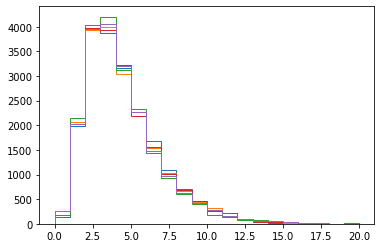

CPU times: user 1min 17s, sys: 7.75 s, total: 1min 25s
Wall time: 31.6 s


In [57]:
def mcmc_mala():
    step_size = 0.5
    
    # TODO understand relationship with HMC
    def kernel_func(logdf):
        return tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
            logdf,
            step_size,
        )
    
    mcmc_generic(
        kernel_func,
        REGION, 
        20, 
        (0., 20.), 
        nsamples=20_000,
        nrepeats=12,
        burnin=500, 
    )
    
%time mcmc_mala()

20000 28569.72024542662 1.428486012271331


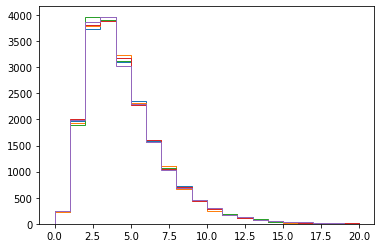

CPU times: user 5min 45s, sys: 26.4 s, total: 6min 12s
Wall time: 2min 38s


In [12]:
def mcmc_nuts():
    step_size = 0.5
    
    def kernel_func(logdf):
        return tfp.mcmc.NoUTurnSampler(
            logdf,
            step_size,
        )
    
    mcmc_generic(
        kernel_func,
        REGION, 
        20, 
        (0., 20.), 
        nsamples=20_000,
        nrepeats=12,
        burnin=500, 
    )
    
%time mcmc_nuts()

20000 12250.990374162582 0.6125495187081291


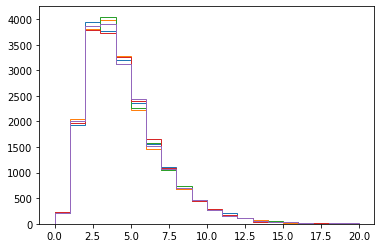

CPU times: user 2min 3s, sys: 11.6 s, total: 2min 14s
Wall time: 53.5 s


In [19]:
def mcmc_ham():
    step_size = 0.5
    num_leapfrog_steps = 2
    
    def kernel_func(logdf):
        return tfp.mcmc.HamiltonianMonteCarlo(
            logdf,
            step_size,
            num_leapfrog_steps,
        )
    
    mcmc_generic(
        kernel_func,
        REGION, 
        20, 
        (0., 20.), 
        nsamples=20_000,
        nrepeats=12,
        burnin=500, 
    )
    
%time mcmc_ham()

200000 4302.313722959345 0.021511568614796726


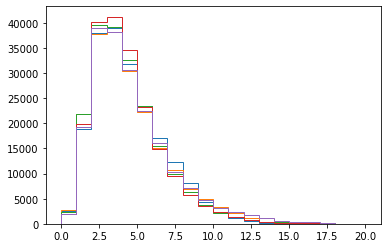

CPU times: user 3min 56s, sys: 29.2 s, total: 4min 26s
Wall time: 1min 32s


In [14]:
def mcmc_walk():
    step_size = 0.2
    
    def kernel_func(logdf):
        return tfp.mcmc.RandomWalkMetropolis(
            logdf,
            new_state_fn=tfp.mcmc.random_walk_normal_fn(scale=step_size),
        )
    
    mcmc_generic(
        kernel_func,
        REGION, 
        20, 
        (0., 20.), 
        nsamples=200_000,
        nrepeats=12,
        burnin=500, 
    )
    
%time mcmc_walk()